# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-5000'
TEST_DATASET_NAME = 'dataset-test'
BATCH_SIZE = 16
MODEL_PATH = 'model/cnn'

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from util import GeneratedDataset

trainset = GeneratedDataset(DATASET_NAME, transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transforms.ToTensor())
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Define CNN based auto-encoder

- 64 * 64 * 3 image input = 12,288
- Cov3 with 32 channel, 3 * 3 * 3 * 32 = 864 parameters
- ReLU
- MaxPool -> 32 * 32 * 32 hidden state = 32768
- Cov3 with 64 channel, 32 * 3 * 3 * 64 = 18432 parameters
- ReLU
- MaxPool -> 16 * 16 * 64 hidden state = 16384
- Cov3 with 128 channel, 64 * 3 * 3 * 128 = 73728 parameters
- ReLU
- MaxPool -> 8 * 8 * 128 = 8192 hidden state
- Full connected 8192 -> **embedding size**

And the decoder works reversely.

In [2]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, embedding_size=32):
        super(Autoencoder, self).__init__()
        self.embedding_size = embedding_size
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.fc1 = nn.Linear(8 * 8 * 128, self.embedding_size)  # Fully connected layer to get 32-length embedding

        # Decoder
        self.fc2 = nn.Linear(self.embedding_size, 8 * 8 * 128)  # Fully connected layer to reshape back to 8x8x128
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)  # Flatten the tensor
        encoded = self.fc1(encoded)  # Get the embedding
        decoded = self.fc2(encoded)  # Reshape back to 8x8x128
        decoded = decoded.view(decoded.size(0), 128, 8, 8)
        decoded = self.decoder(decoded)
        return decoded, encoded

In [3]:
from util import train_model_steps, plot_model, count_parameters, calculate_metrics, save_to_file, load_from_file, print_matrix, plot_conf_matrix

def train_model(embedding_size=32, learning_rate=1e-4, weight_decay=1e-5, num_epochs=20):
    # Initialize the model
    model = Autoencoder(embedding_size=embedding_size)
    print(f'Number of parameters: {count_parameters(model)}')

    model_path = f'{MODEL_PATH}/e{embedding_size}.pth'
    stat_path = f'{MODEL_PATH}/e{embedding_size}.pkl'
    if os.path.exists(model_path) and os.path.exists(stat_path):
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        train_losses, test_losses = load_from_file(stat_path)
    else:
        model, train_losses, test_losses = train_model_steps(model, trainloader, testloader, learning_rate, weight_decay, num_epochs)
        # Save the model
        torch.save(model.state_dict(), model_path)
        save_to_file((train_losses, test_losses), stat_path)

    metrics = calculate_metrics(model, testset)
    print_matrix(metrics)
    plot_conf_matrix(metrics['conf_matrix'])
    plot_model(model, train_losses, test_losses, testset)
    return model, train_losses, test_losses

## Evaluation

Testing with embedding size of (down from 8192)
- 4
- 8
- 16
- 32
- 64

Number of parameters: 407687
Epoch [1/20], Train Loss: 0.3040, Test Loss: 0.2278
Epoch [2/20], Train Loss: 0.1636, Test Loss: 0.1466
Epoch [3/20], Train Loss: 0.1388, Test Loss: 0.1408
Epoch [4/20], Train Loss: 0.1345, Test Loss: 0.1367
Epoch [5/20], Train Loss: 0.1310, Test Loss: 0.1341
Epoch [6/20], Train Loss: 0.1281, Test Loss: 0.1311
Epoch [7/20], Train Loss: 0.1257, Test Loss: 0.1292
Epoch [8/20], Train Loss: 0.1242, Test Loss: 0.1280
Epoch [9/20], Train Loss: 0.1230, Test Loss: 0.1271
Epoch [10/20], Train Loss: 0.1220, Test Loss: 0.1272
Epoch [11/20], Train Loss: 0.1212, Test Loss: 0.1256
Epoch [12/20], Train Loss: 0.1203, Test Loss: 0.1248
Epoch [13/20], Train Loss: 0.1199, Test Loss: 0.1242
Epoch [14/20], Train Loss: 0.1194, Test Loss: 0.1240
Epoch [15/20], Train Loss: 0.1190, Test Loss: 0.1239
Epoch [16/20], Train Loss: 0.1187, Test Loss: 0.1233
Epoch [17/20], Train Loss: 0.1185, Test Loss: 0.1232
Epoch [18/20], Train Loss: 0.1183, Test Loss: 0.1231
Epoch [19/20], Train Loss:

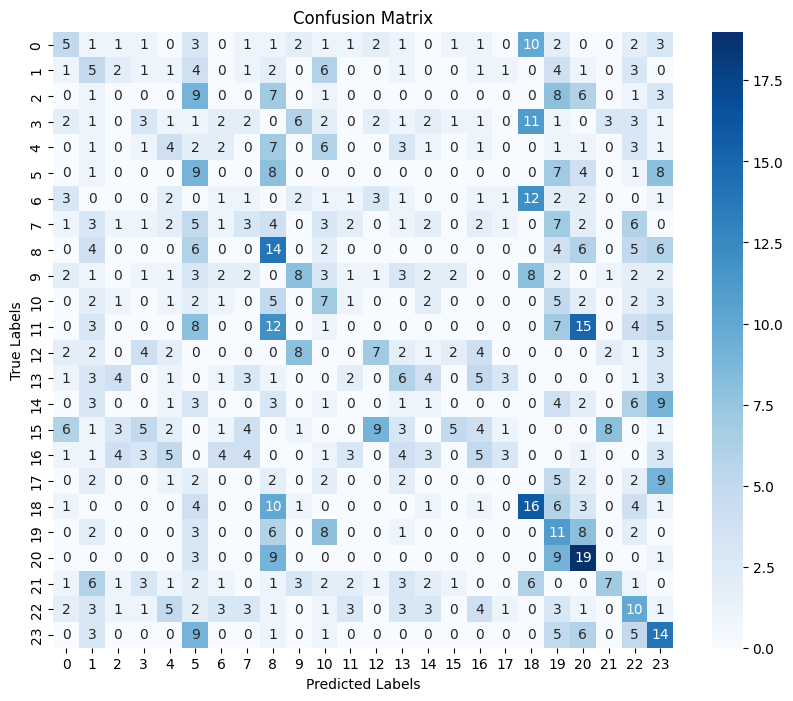

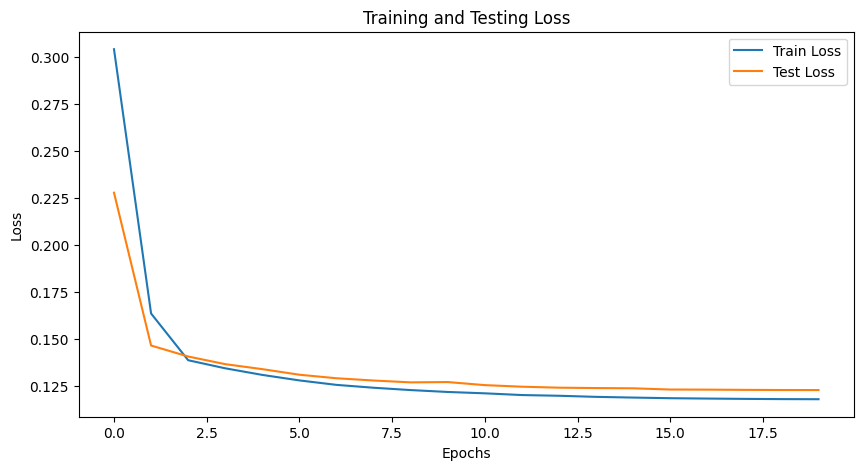

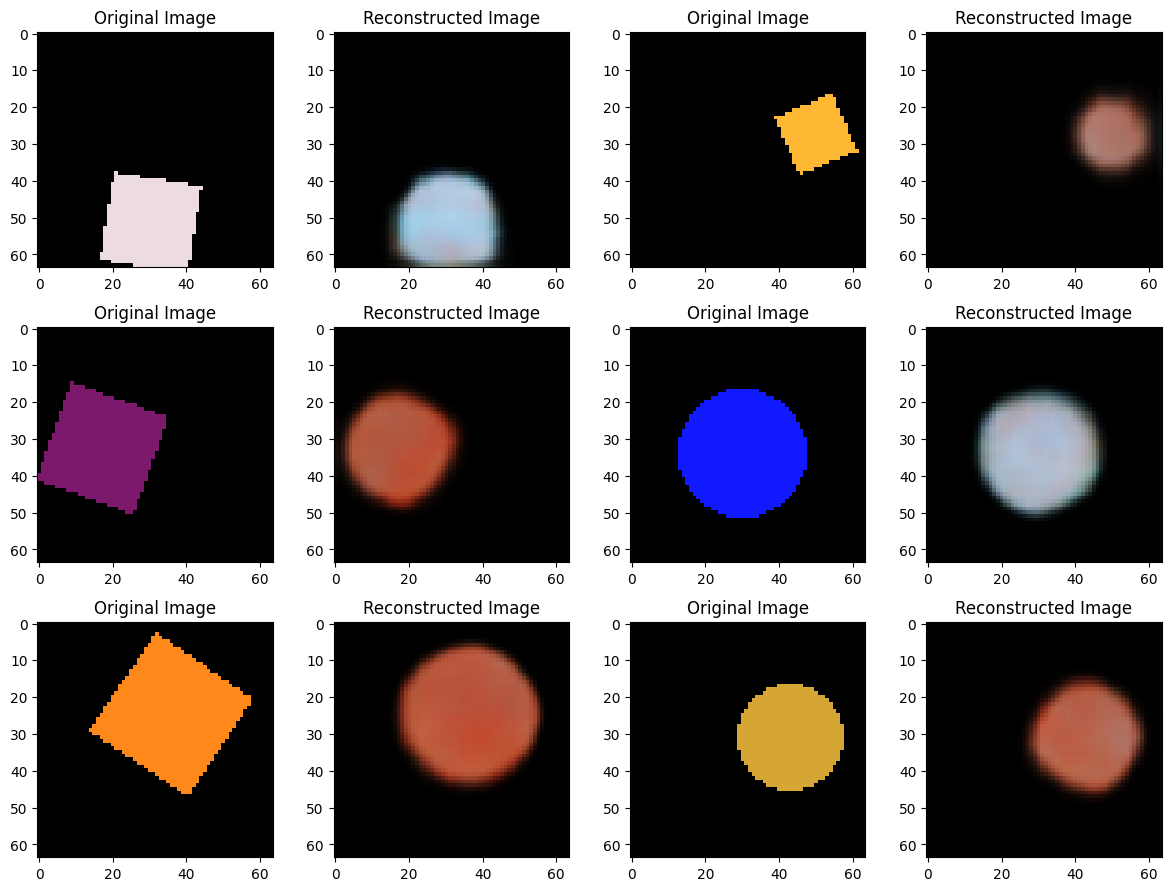

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=4, bias=True)
   (fc2): Linear(in_features=4, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): Upsample(scale_fact

In [4]:
train_model(4)

Number of parameters: 473227
Epoch [1/20], Train Loss: 0.2897, Test Loss: 0.1732
Epoch [2/20], Train Loss: 0.1437, Test Loss: 0.1413
Epoch [3/20], Train Loss: 0.1340, Test Loss: 0.1359
Epoch [4/20], Train Loss: 0.1229, Test Loss: 0.1177
Epoch [5/20], Train Loss: 0.1115, Test Loss: 0.1119
Epoch [6/20], Train Loss: 0.1076, Test Loss: 0.1106
Epoch [7/20], Train Loss: 0.1054, Test Loss: 0.1086
Epoch [8/20], Train Loss: 0.1034, Test Loss: 0.1058
Epoch [9/20], Train Loss: 0.1016, Test Loss: 0.1056
Epoch [10/20], Train Loss: 0.1000, Test Loss: 0.1046
Epoch [11/20], Train Loss: 0.0985, Test Loss: 0.1024
Epoch [12/20], Train Loss: 0.0971, Test Loss: 0.1009
Epoch [13/20], Train Loss: 0.0957, Test Loss: 0.0997
Epoch [14/20], Train Loss: 0.0946, Test Loss: 0.0990
Epoch [15/20], Train Loss: 0.0935, Test Loss: 0.0981
Epoch [16/20], Train Loss: 0.0927, Test Loss: 0.0976
Epoch [17/20], Train Loss: 0.0921, Test Loss: 0.0973
Epoch [18/20], Train Loss: 0.0917, Test Loss: 0.0971
Epoch [19/20], Train Loss:

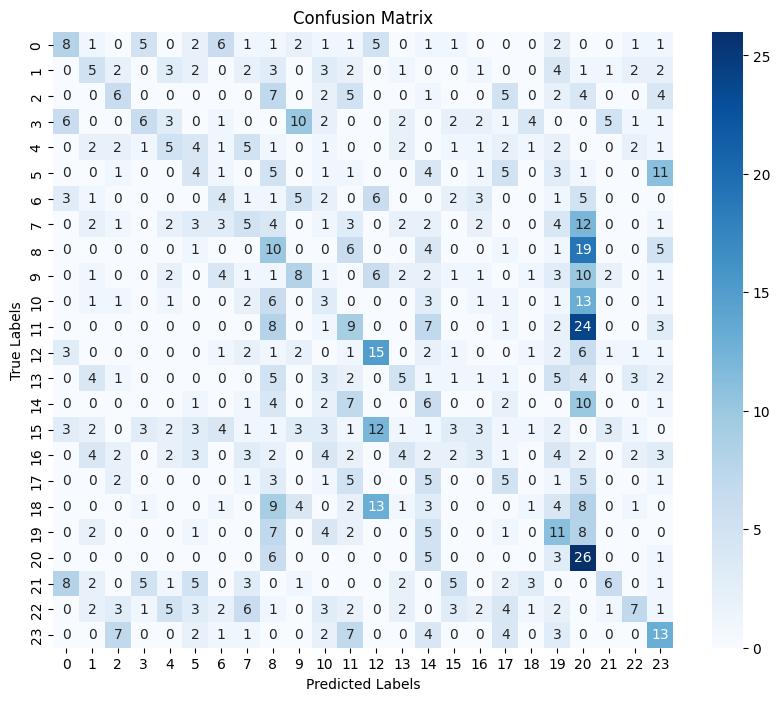

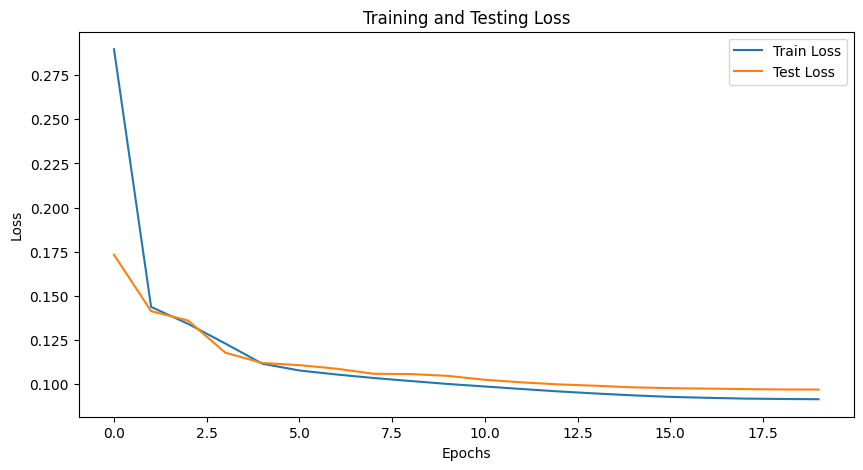

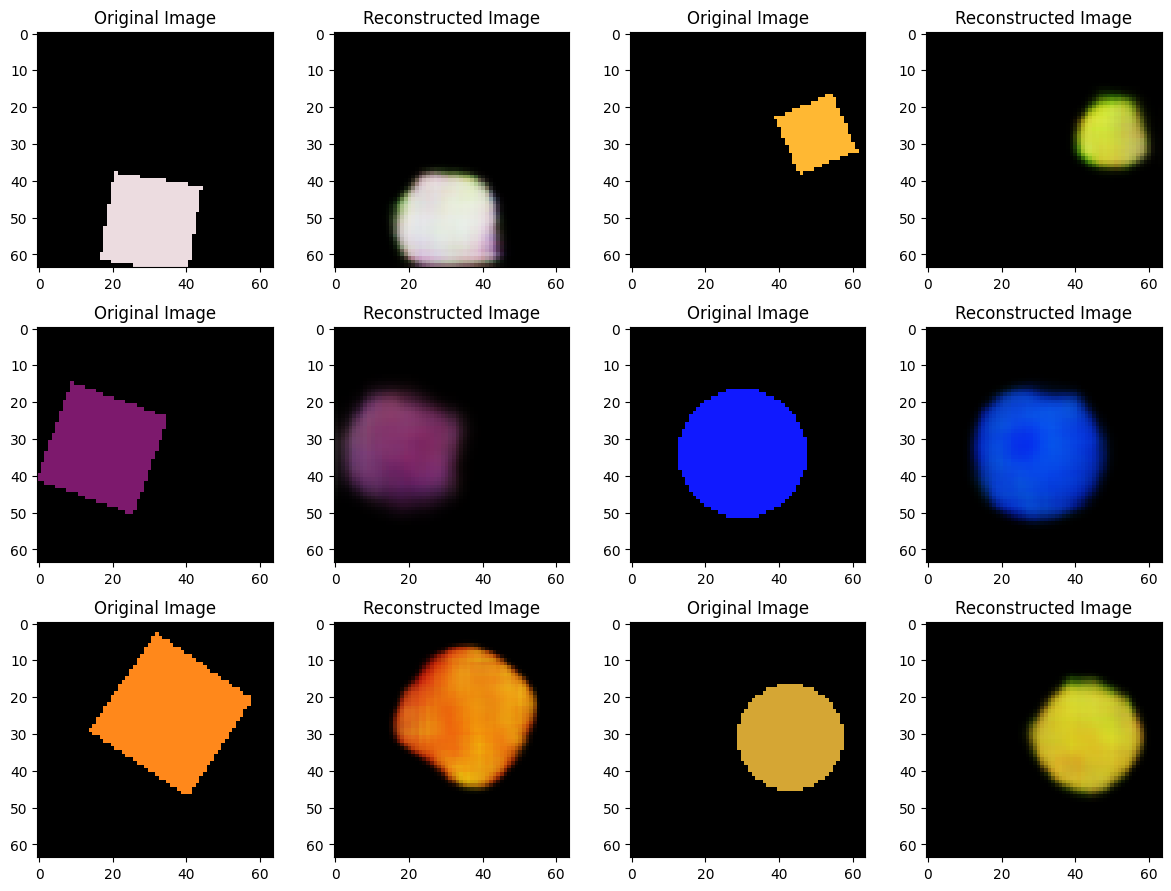

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=8, bias=True)
   (fc2): Linear(in_features=8, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): Upsample(scale_fact

In [5]:
train_model(8)

Number of parameters: 604307
Epoch [1/20], Train Loss: 0.2805, Test Loss: 0.1586
Epoch [2/20], Train Loss: 0.1408, Test Loss: 0.1414
Epoch [3/20], Train Loss: 0.1346, Test Loss: 0.1365
Epoch [4/20], Train Loss: 0.1295, Test Loss: 0.1316
Epoch [5/20], Train Loss: 0.1240, Test Loss: 0.1255
Epoch [6/20], Train Loss: 0.1155, Test Loss: 0.1137
Epoch [7/20], Train Loss: 0.1068, Test Loss: 0.1082
Epoch [8/20], Train Loss: 0.1033, Test Loss: 0.1058
Epoch [9/20], Train Loss: 0.1004, Test Loss: 0.1029
Epoch [10/20], Train Loss: 0.0983, Test Loss: 0.1012
Epoch [11/20], Train Loss: 0.0964, Test Loss: 0.1003
Epoch [12/20], Train Loss: 0.0943, Test Loss: 0.0977
Epoch [13/20], Train Loss: 0.0917, Test Loss: 0.0952
Epoch [14/20], Train Loss: 0.0893, Test Loss: 0.0935
Epoch [15/20], Train Loss: 0.0876, Test Loss: 0.0919
Epoch [16/20], Train Loss: 0.0866, Test Loss: 0.0909
Epoch [17/20], Train Loss: 0.0860, Test Loss: 0.0905
Epoch [18/20], Train Loss: 0.0855, Test Loss: 0.0901
Epoch [19/20], Train Loss:

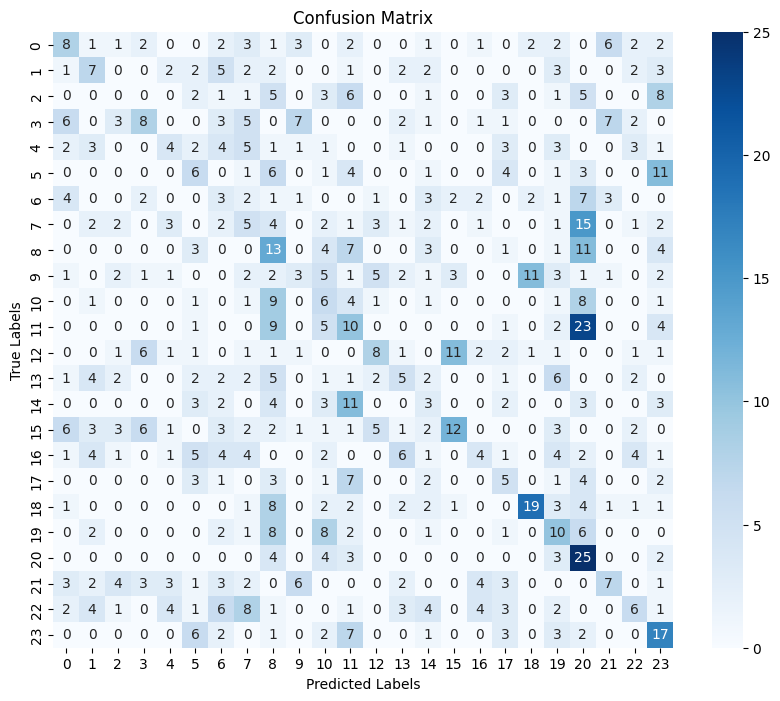

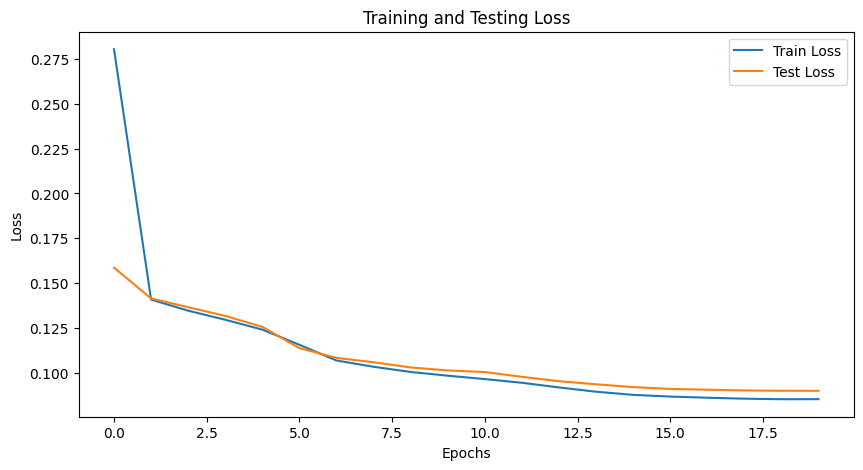

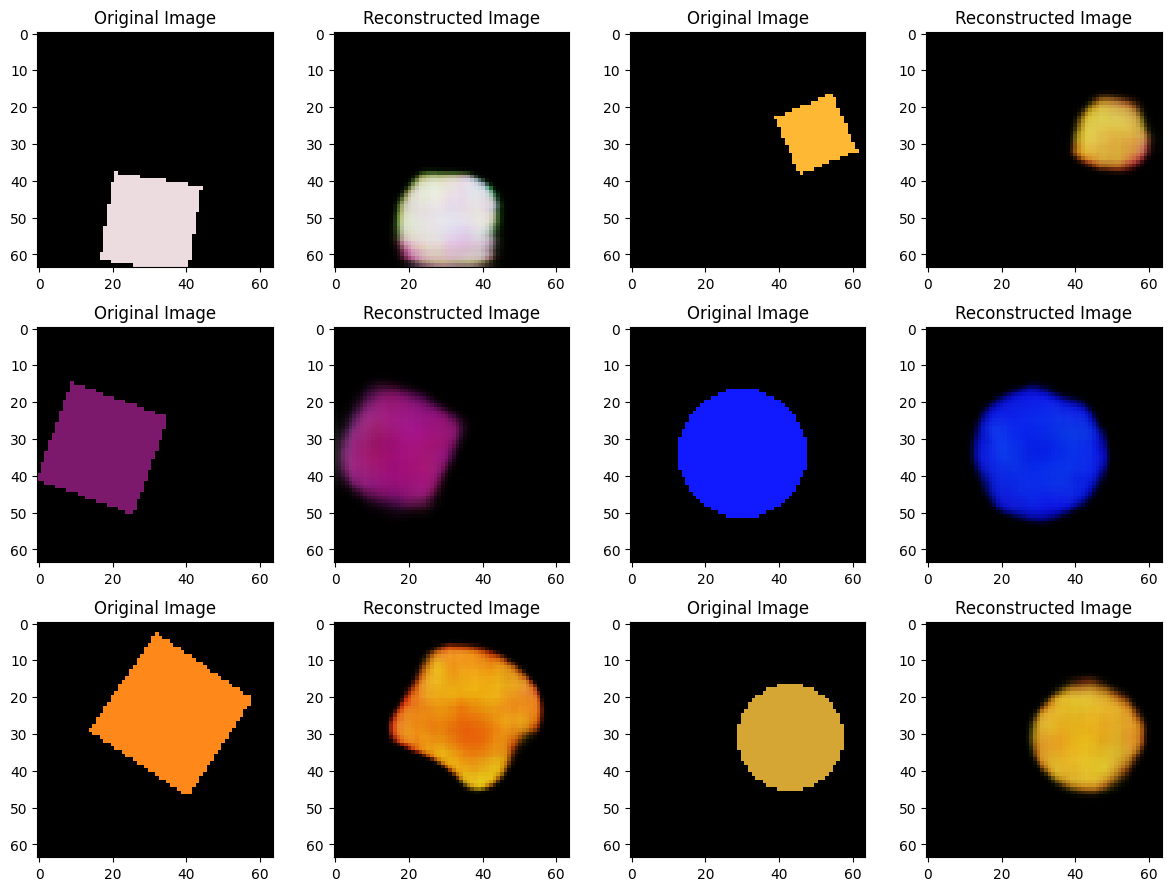

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=16, bias=True)
   (fc2): Linear(in_features=16, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): Upsample(scale_fa

In [6]:
train_model(16)

Number of parameters: 866467
Epoch [1/20], Train Loss: 0.2827, Test Loss: 0.1521
Epoch [2/20], Train Loss: 0.1397, Test Loss: 0.1396
Epoch [3/20], Train Loss: 0.1339, Test Loss: 0.1364
Epoch [4/20], Train Loss: 0.1305, Test Loss: 0.1328
Epoch [5/20], Train Loss: 0.1264, Test Loss: 0.1290
Epoch [6/20], Train Loss: 0.1212, Test Loss: 0.1212
Epoch [7/20], Train Loss: 0.1106, Test Loss: 0.1079
Epoch [8/20], Train Loss: 0.1026, Test Loss: 0.1048
Epoch [9/20], Train Loss: 0.1000, Test Loss: 0.1023
Epoch [10/20], Train Loss: 0.0979, Test Loss: 0.1006
Epoch [11/20], Train Loss: 0.0962, Test Loss: 0.0992
Epoch [12/20], Train Loss: 0.0946, Test Loss: 0.0980
Epoch [13/20], Train Loss: 0.0933, Test Loss: 0.0972
Epoch [14/20], Train Loss: 0.0922, Test Loss: 0.0958
Epoch [15/20], Train Loss: 0.0909, Test Loss: 0.0953
Epoch [16/20], Train Loss: 0.0900, Test Loss: 0.0945
Epoch [17/20], Train Loss: 0.0893, Test Loss: 0.0939
Epoch [18/20], Train Loss: 0.0888, Test Loss: 0.0935
Epoch [19/20], Train Loss:

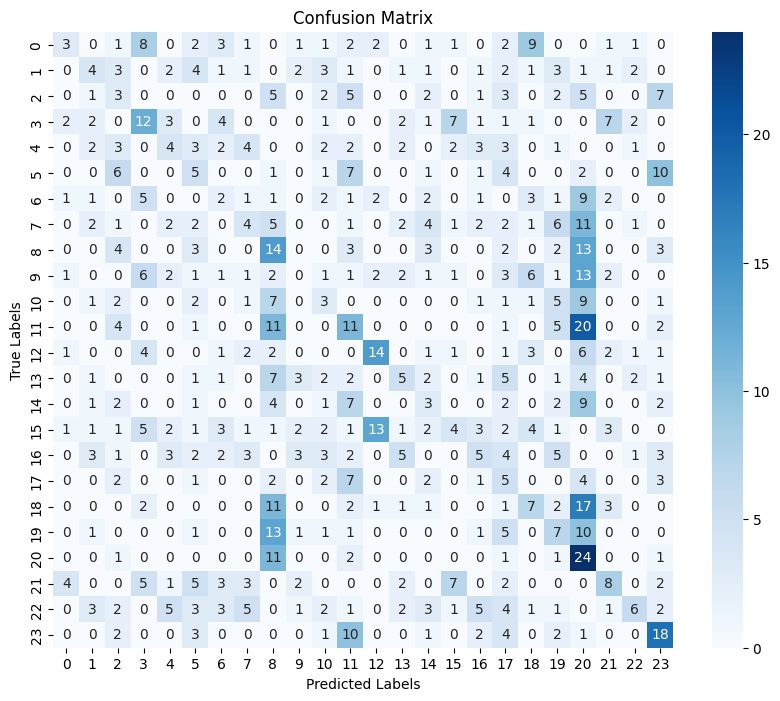

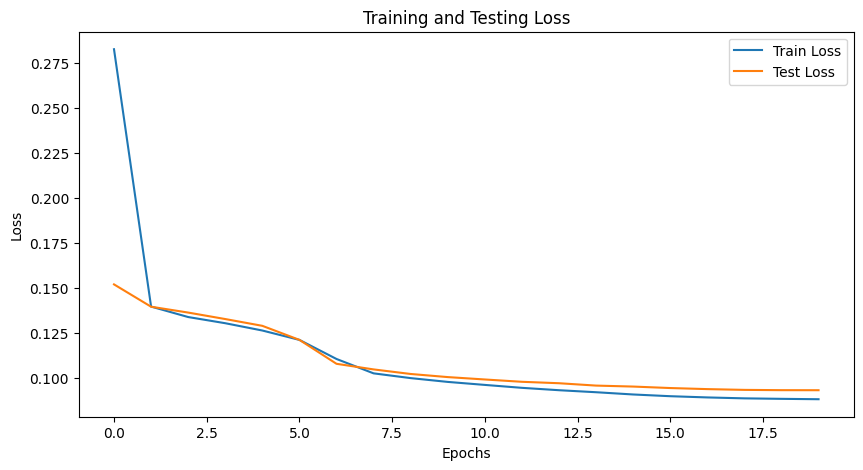

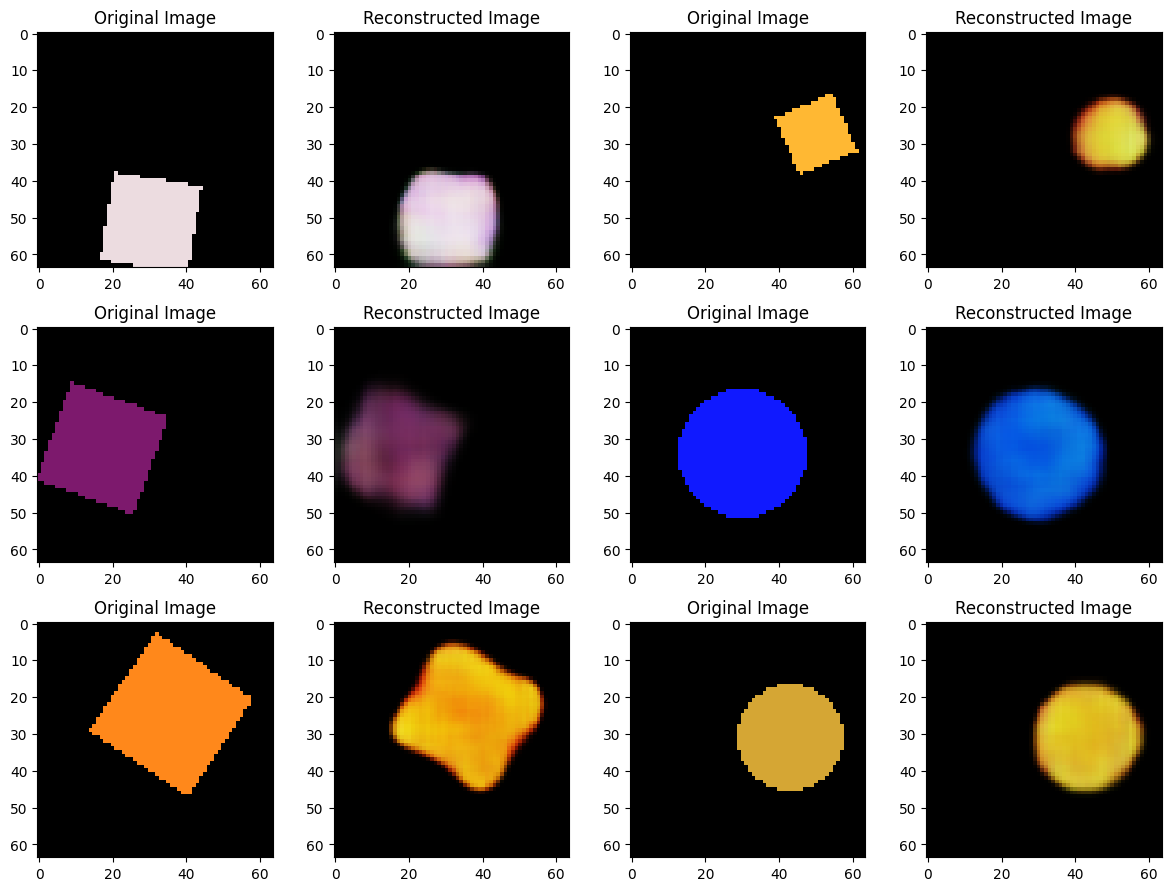

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): Upsample(scale_fa

In [7]:
train_model(32)

Number of parameters: 1390787
Epoch [1/20], Train Loss: 0.2759, Test Loss: 0.1531
Epoch [2/20], Train Loss: 0.1405, Test Loss: 0.1407
Epoch [3/20], Train Loss: 0.1337, Test Loss: 0.1351
Epoch [4/20], Train Loss: 0.1271, Test Loss: 0.1285
Epoch [5/20], Train Loss: 0.1199, Test Loss: 0.1201
Epoch [6/20], Train Loss: 0.1104, Test Loss: 0.1093
Epoch [7/20], Train Loss: 0.1041, Test Loss: 0.1056
Epoch [8/20], Train Loss: 0.1007, Test Loss: 0.1041
Epoch [9/20], Train Loss: 0.0982, Test Loss: 0.1006
Epoch [10/20], Train Loss: 0.0960, Test Loss: 0.0991
Epoch [11/20], Train Loss: 0.0933, Test Loss: 0.0966
Epoch [12/20], Train Loss: 0.0907, Test Loss: 0.0947
Epoch [13/20], Train Loss: 0.0881, Test Loss: 0.0924
Epoch [14/20], Train Loss: 0.0861, Test Loss: 0.0905
Epoch [15/20], Train Loss: 0.0849, Test Loss: 0.0894
Epoch [16/20], Train Loss: 0.0839, Test Loss: 0.0884
Epoch [17/20], Train Loss: 0.0834, Test Loss: 0.0880
Epoch [18/20], Train Loss: 0.0830, Test Loss: 0.0878
Epoch [19/20], Train Loss

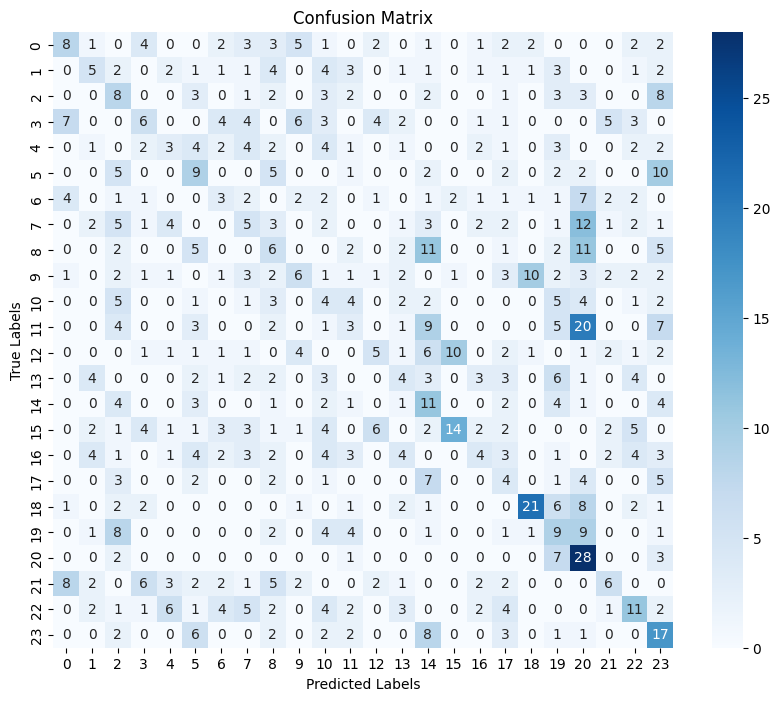

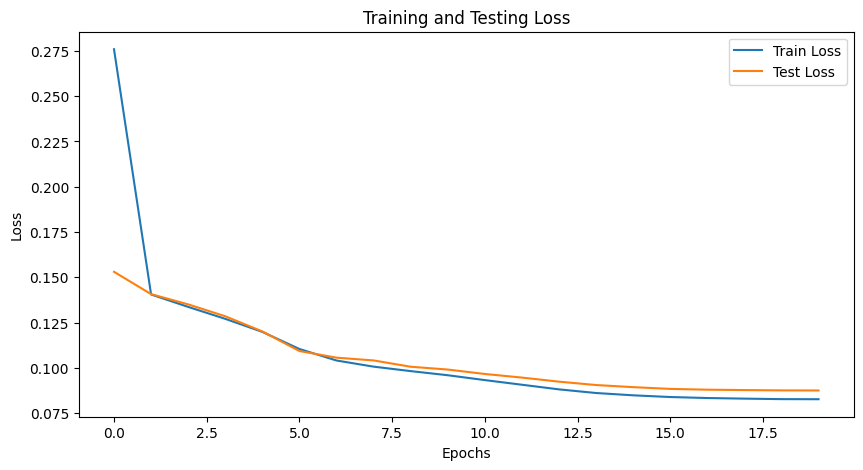

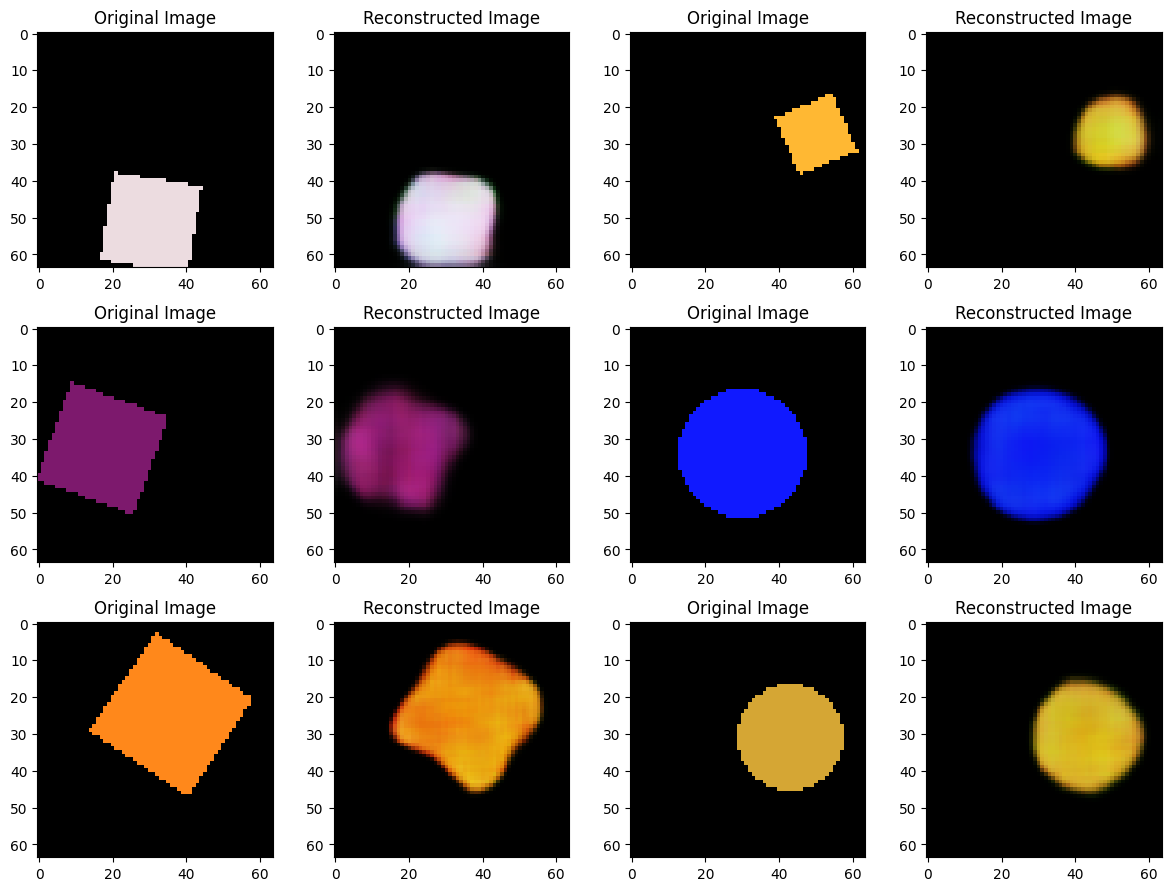

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=64, bias=True)
   (fc2): Linear(in_features=64, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): Upsample(scale_fa

In [8]:
train_model(64)